PYTORCH MODEL IMPLEMENTATION - CK+ DATASET

IMPORTING LIBRARIES

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import transforms

PYTORCH - LOADING THE IMAGE DATASET & SETTING IMAGE SIZE, & EMOTION CLASS 

In [9]:
# Set the path to the folder containing images
data_path = "C:/Users/HP/Desktop/MSc Thesis/DATASETS/CK+ Datasets/CK+48"

# Define the emotion classes
emotion_classes = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Set the image size
image_size = (48, 48)

ATTENTION!!!

PYTORCH DATA PREPROCESSING (NO HYPERPARAMETER TUNING) - CK+
Run this data preprocessing cell immediately below if you intend to run the PyTorch model without hyperparameter tuning implemented. 

If you want to run the PyTorch model with hyperparameter tuning, then skip the cell (7) below and run the data run cell (10) below by scrolling a bit.

In [7]:
# Function to load the images and labels
def load_data():
    images = []
    labels = []
    for emotion_class in emotion_classes:
        class_path = os.path.join(data_path, emotion_class)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path).convert('L')  # Convert the images to grayscale
            image = image.resize(image_size)
            images.append(torch.from_numpy(np.array(image)))
            labels.append(emotion_classes.index(emotion_class))
    return images, labels

images, labels = load_data()

# Split the data into training, validation and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# PyTorch custom dataset class for emotion dataset
class EmotionDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].unsqueeze(0).float() / 255
        label = self.labels[idx]

        if self.transforms:
            image = self.transforms(image)

        return image, label

# Create PyTorch datasets and data loaders for training, validation and testing
train_dataset = EmotionDataset(X_train, y_train)
val_dataset = EmotionDataset(X_val, y_val)
test_dataset = EmotionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

ATTENTION!!! 

PYTORCH MODEL TRAINING WITHOUT HYPERPARAMETER TUNING - CK+

In [ ]:
import psutil

# Function to convert bytes to megabytes
def bytes_to_megabytes(bytes):
    return bytes / (1024.0 ** 2)

# Initial RAM usage
initial_memory = psutil.virtual_memory().used
print(f"Initial RAM used: {bytes_to_megabytes(initial_memory):.2f} MB")

# Define the CNN model class
class EmotionNet(nn.Module):
    def __init__(self):
        super(EmotionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, len(emotion_classes))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.dropout(x, p=0.25)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.dropout(x, p=0.25)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.log_softmax(self.fc2(x), dim=1) 
        return x

# Create the model
model = EmotionNet()

# RAM usage after model creation
after_creation_memory = psutil.virtual_memory().used
print(f"RAM used after model creation: {bytes_to_megabytes(after_creation_memory):.2f} MB")
print(f"Approximate RAM used during model creation: {bytes_to_megabytes(after_creation_memory - initial_memory):.2f} MB")

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch in range(20):  
    for i, (inputs, labels) in enumerate(train_loader):  
        outputs = model(inputs)  
        loss = criterion(outputs, labels)

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step() 

    print('Epoch {}/{}'.format(epoch+1, 20))

# Evaluation setup
model.eval() 
correct = 0
total = 0
with torch.no_grad(): 
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
# RAM usage after training
after_training_memory = psutil.virtual_memory().used
print(f"RAM used after model training: {bytes_to_megabytes(after_training_memory):.2f} MB")
print(f"Approximate RAM used during training: {bytes_to_megabytes(after_training_memory - after_creation_memory):.2f} MB")

# Printing Test accuracy 
print('Test Accuracy: %d %%' % (100 * correct / total))

ATTENTION!!!

DATA PREPROCESSING FOR THE PYTORCH MODEL WITH HYPERPARAMETERS TUNING
Please run this data processing if you intend to run the PyTorch model that has Hyperparameter tuning implemented, otherwise, run the data processing above.

In [10]:
# Function to load the images and labels
def load_data():
    images = []
    labels = []
    for emotion_class in emotion_classes:
        class_path = os.path.join(data_path, emotion_class)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path).convert('L')
            image = image.resize(image_size)
            images.append(torch.from_numpy(np.array(image)))
            labels.append(emotion_classes.index(emotion_class))
    return images, labels

# Function to create data loaders
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, val_loader, test_loader

# PyTorch custom dataset class for emotion dataset
class EmotionDataset(Dataset):
    def __init__(self, images, labels, transforms=None):
        self.images = images
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].unsqueeze(0).float() / 255
        label = self.labels[idx]

        if self.transforms:
            image = self.transforms(image)

        return image, label

PYTORCH MODEL TRAINING WITH HYPERPARAMETER TUNING - CK+

In [ ]:
import psutil

# Function to convert bytes to megabytes
def bytes_to_megabytes(bytes):
    return bytes / (1024.0 ** 2)

# Initial RAM usage
initial_memory = psutil.virtual_memory().used
print(f"Initial RAM used: {bytes_to_megabytes(initial_memory):.2f} MB")

# CNN model class
class EmotionNet(nn.Module):
    def __init__(self):
        super(EmotionNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, len(emotion_classes))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.dropout(x, p=0.25)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.dropout(x, p=0.25)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

# Hyperparameter tuning
batch_sizes = [32, 64]
num_epochs_list = [10, 20]

for batch_size in batch_sizes:
    for num_epochs in num_epochs_list:
        print(f"Training with batch size {batch_size} and {num_epochs} epochs.")

        # Load data
        images, labels = load_data()

        # Split data
        X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

        # Create datasets
        train_dataset = EmotionDataset(X_train, y_train)
        val_dataset = EmotionDataset(X_val, y_val)
        test_dataset = EmotionDataset(X_test, y_test)

        # Create data loaders
        train_loader, val_loader, test_loader = create_dataloaders(batch_size)

        # Create model
        model = EmotionNet()

        # RAM usage after model creation
        after_creation_memory = psutil.virtual_memory().used
        print(f"RAM used after model creation: {bytes_to_megabytes(after_creation_memory):.2f} MB")
        print(f"Approximate RAM used during model creation: {bytes_to_megabytes(after_creation_memory - initial_memory):.2f} MB")

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters())

        # Training loop
        for epoch in range(num_epochs):
            for i, (inputs, labels) in enumerate(train_loader):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            print(f"Epoch {epoch+1}/{num_epochs}")

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        # RAM usage after training
        after_training_memory = psutil.virtual_memory().used
        print(f"RAM used after model training: {bytes_to_megabytes(after_training_memory):.2f} MB")
        print(f"Approximate RAM used during training: {bytes_to_megabytes(after_training_memory - after_creation_memory):.2f} MB")
        print(" ")
        print(f"Test Accuracy for batch size {batch_size} and {num_epochs} epochs: {100 * correct / total}%")
        print(" ")

PyTorch - TEST ACCURACIES - CK+

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to monitor test loss and accuracy
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Training loop
for epoch in range(100):  
    train_correct = 0
    val_correct = 0
    for inputs, labels in train_loader:  
        outputs = model(inputs)  
        loss = criterion(outputs, labels)  

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step() 

        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()

    with torch.no_grad(): 
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    train_acc = train_correct / len(train_dataset)
    val_acc = val_correct / len(val_dataset)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{100}.. Train accuracy: {train_acc:.3f}.. Val accuracy: {val_acc:.3f}')

# Test the model and calculate accuracy after training
model.eval() 
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = correct / total
test_accuracies = [test_acc] * len(train_accuracies)
print('Test Accuracy: %d %%' % (100 * test_acc))

PYTORCH - ACCURACY PLOT FOR CK+ DATASET

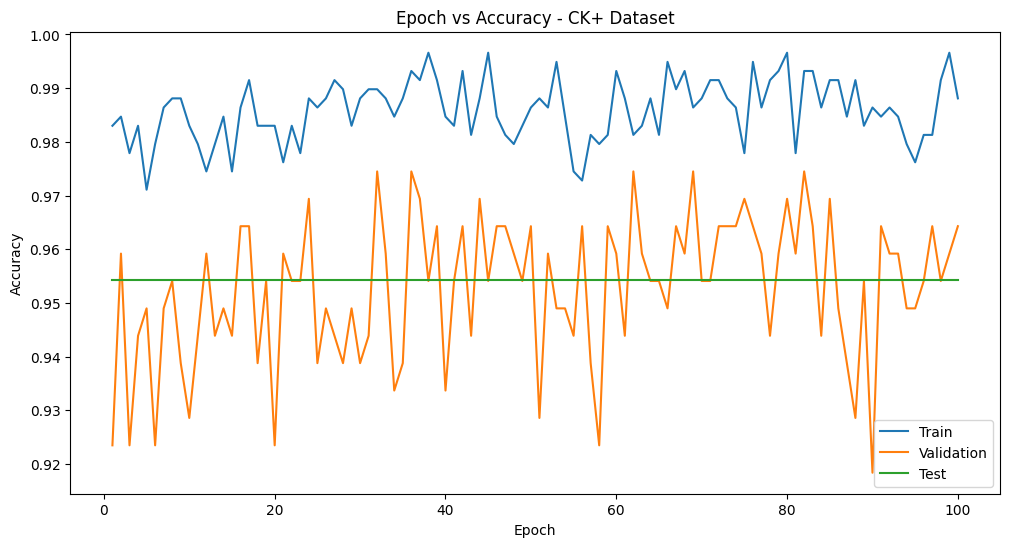

In [8]:
# Plot the training, validation, and test accuracies
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation')
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, label='Test')
plt.title('Epoch vs Accuracy - CK+ Dataset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

PYTORCH - ERROR RATE vs EPOCH PLOT - CK+

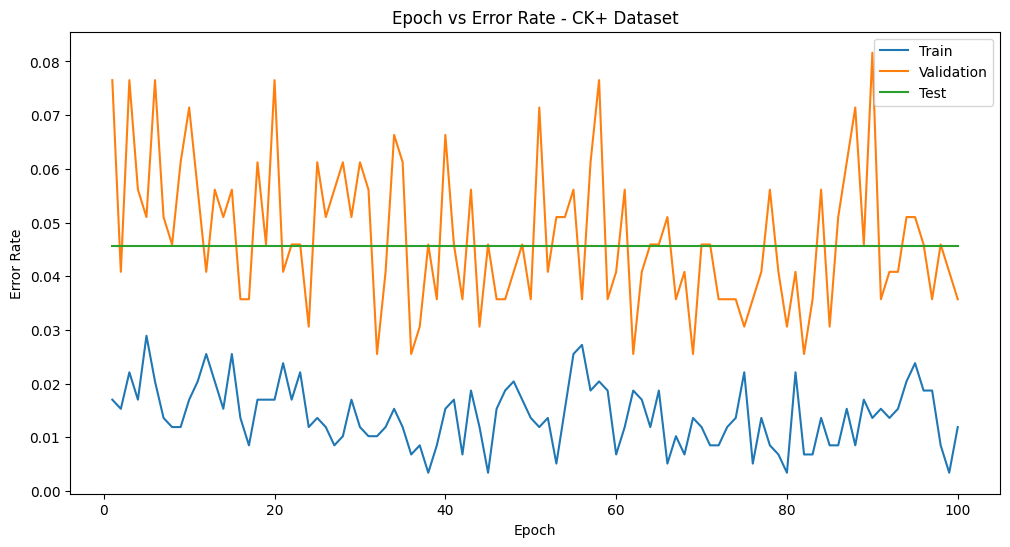

In [9]:
# Compute error rates from accuracies
train_error_rates = [1 - acc for acc in train_accuracies]
val_error_rates = [1 - acc for acc in val_accuracies]
test_error_rates = [1 - acc for acc in test_accuracies]

# Plot training, validation, and test error rates
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_error_rates) + 1), train_error_rates, label='Train')
plt.plot(range(1, len(val_error_rates) + 1), val_error_rates, label='Validation')
plt.plot(range(1, len(test_error_rates) + 1), test_error_rates, label='Test')
plt.title('Epoch vs Error Rate - CK+ Dataset')
plt.xlabel('Epoch')
plt.ylabel('Error Rate')
plt.legend()
plt.show()

PYTORCH - CLASSIFICATION REPORT - CK+

In [10]:
from sklearn.metrics import classification_report

# Define your class names
class_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

# Initialize lists to gather true and predicted labels
true_labels = []
pred_labels = []

# Set the model to evaluation mode
model.eval()

# Compute predictions on the test data
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Add true labels and predicted labels
        true_labels.extend(labels.numpy())  
        pred_labels.extend(predicted.numpy()) 

# Compute and print the classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))

              precision    recall  f1-score   support

       anger       0.91      0.87      0.89        23
    contempt       1.00      0.89      0.94         9
     disgust       0.96      1.00      0.98        43
        fear       0.93      0.93      0.93        15
       happy       1.00      1.00      1.00        43
     sadness       0.89      0.89      0.89        19
    surprise       1.00      1.00      1.00        45

    accuracy                           0.96       197
   macro avg       0.96      0.94      0.95       197
weighted avg       0.96      0.96      0.96       197



PYTORCH - COMPUTING AND PLOTTING THE CONFUSION MATRIX - CK+

Test Accuracy: 96 %


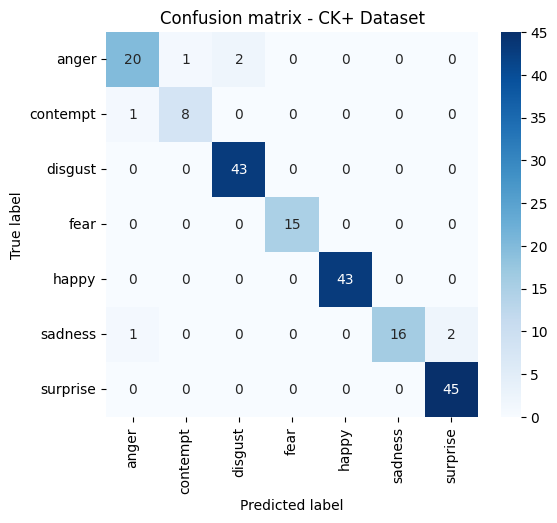

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Classes names
class_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']


# Initialize list for storing model predictions and actual labels
all_preds = []
all_labels = []

# Set the model to evaluation mode
model.eval()  
correct = 0
total = 0
with torch.no_grad(): 
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and actual labels
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

test_acc = correct / total
test_accuracies = [test_acc] * len(train_accuracies)
print('Test Accuracy: %d %%' % (100 * test_acc))

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix - CK+ Dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

PYTORCH - PLOTTING THE ROC CURVE - CK+

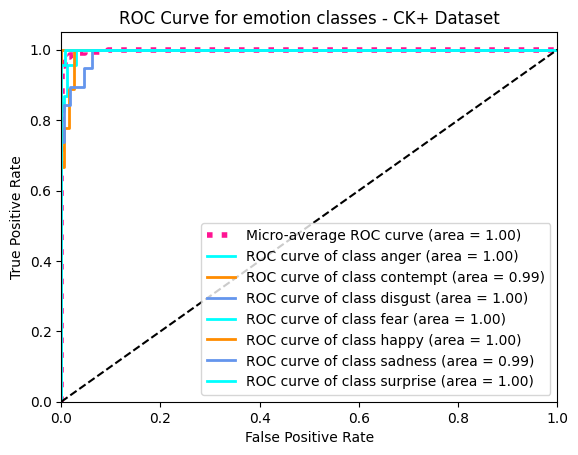

In [14]:
# Additional import
import torch.nn.functional as F

# Initialize list for storing model predictions, actual labels, and predicted probabilities
all_preds = []
all_labels = []
all_probs = []  

# Set the model to evaluation mode
model.eval()  
correct = 0
total = 0
with torch.no_grad():  
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Convert outputs to probabilities using softmax and store
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and actual labels
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Convert the list of probabilities to a numpy array
all_probs_np = np.array(all_probs)

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output
class_names = ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise'] 
y_bin = label_binarize(all_labels, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs_np[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), all_probs_np.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'
                                           ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for emotion classes - CK+ Dataset')
plt.legend(loc="lower right")
plt.show()